**Fachprojekt Dokumentenanalyse** *WS 22/23* -- *Philipp Oberdiek, Gernot A. Fink* -- *Technische Universität Dortmund, Lehrstuhl XII, Mustererkennung in eingebetteten Systemen*
---
# Aufgabe 3: Kreuzvalidierung, Term Weighting


Um eine willkürliche Aufteilung der Daten in Training und Test zu vermeiden (machen Sie sich bewusst warum das problematisch ist), verwendet man zur Evaluierung von Klassifikatoren eine Kreuzvalidierung. Dabei wird der gesamte Datensatz in k disjunkte Ausschnitte (Folds) aufgeteilt. Jeder dieser Ausschnitte wird einmal als Test Datensatz verwendet, während alle anderen k-1 Ausschnitte als Trainings Datensatz verwendet werden. Man erhählt also k Gesamtfehlerraten und k klassenspezifische Fehlerraten die man jeweils zu einer gemeinsamen Fehlerrate für die gesamte Kreuzvalidierung mittelt. Beachten Sie, dass dabei ein gewichtetes Mittel gebildet werden muss, da die einzelnen Test Folds nicht unbedingt gleich groß sein müssen.

Erweitern Sie ihre Implementierung des Nächste-Nachbar Klassifikators auf mehrere Nachbarn. Führen Sie aufbauend auf den Ergebnissen aus Aufgabe 2 eine 5-Fold Kreuzvalidierung für den k-Nächste-Nachbarn Klassifikator auf dem Brown Corpus durch. Dazu können Sie die Klasse `CrossValidation` im [`evaluation`](../common/evaluation.py) Modul verwenden.

Vollziehen Sie dazu nach wie die Klasse die Daten in Trainging und Test Folds aufteilt. Fertigen Sie zu dem Schema eine Skizze an. Diskutieren Sie Vorteile und Nachteile. Schauen Sie sich an, wie die eigentliche Kreuzvalidierung funktioniert.

**Hinweise:**

Die Klasse `CrossValidator` verwendet die Klasse `ClassificationEvaluator`, die Sie schon für Aufgabe 2 implementieren sollten. Kontrollieren Sie Ihre Umsetzung im Sinne der Verwendung im `CrossValidator`.

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import sys

if ".." not in sys.path:
    sys.path.append("..")

from common.corpus import CorpusLoader
brown = CorpusLoader.brown_corpus()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Testen Sie ihre Implementierung des erweiterten Nächste-Nachbar Klassifikators mit folgendem Unittest:

In [4]:
import unittest

from utest.test_classification import ClassificationTest

suite = unittest.TestSuite()
suite.addTest(ClassificationTest("test_knn"))
runner = unittest.TextTestRunner()
runner.run(suite)

.

knn_test



----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [5]:
from nltk.corpus import CategorizedCorpusReader

brown : CategorizedCorpusReader = CorpusLoader.brown_corpus()
brown_categories = brown.categories()
brown_documents = brown.fileids()
brown_words = brown.words()

In [6]:
from common.features import BagOfWords, WordListNormalizer
stop_words = CorpusLoader.stopwords_corpus()
normalizer =  WordListNormalizer(stop_words)
words , stemmed_words  = normalizer.normalize_words(brown_words)
vocabulary = BagOfWords.most_freq_words(stemmed_words , 500)
category_wordlists_dict = {}
for category in brown_categories:
	category_wordlists_dict[category] = []
	docs = brown.fileids(categories=category)
	for doc in docs: 
		words  = brown.words(fileids=doc)
		category_wordlists_dict[category].append(words)
bow = BagOfWords(vocabulary)
category_bow_dict = bow.category_bow_dict(category_wordlists_dict)

In [7]:
from common.features import BagOfWords, WordListNormalizer
from common.classification import KNNClassifier
from common.evaluation import CrossValidation
from common.visualization import hbar_plot

def processCategoryBowDict(category_bow_dict):
	cv = CrossValidation(category_bow_dict , 5)
	knn_classifier = KNNClassifier(k_neighbors=3, metric='euclidean')
	crossval_overall_result, crossval_class_results = cv.validate(knn_classifier)
	print("cross val overall result" , crossval_overall_result)
	categories = [res[0] for res in crossval_class_results]
	categories_results = [res[1] for res in crossval_class_results]
	hbar_plot( categories_results , categories)



cross val overall result 74.60000000000001


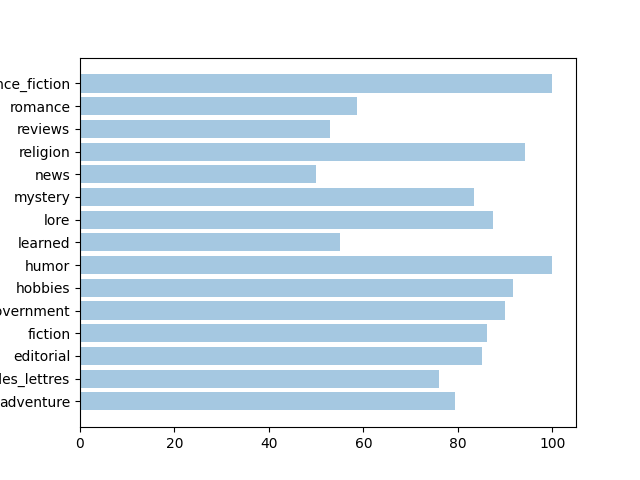

In [8]:
processCategoryBowDict(category_bow_dict)

# Bag-of-Words Weighting

Bisher enthalten die Bag-of-Words Histogramme absolute Frequenzen. Dadurch sind die Repräsentationen abhängig von der absoluten Anzahl von Wörtern in den Dokumenten. Dies kann vermieden werden, indem man die Bag-of-Words Histogramme mit einem Normalisierungsfaktor gewichtet.

Normalisieren Sie die Bag-of-Words Histogramme so, dass relative Frequenzen verwendet werden. Implementieren und verwenden Sie die Klasse `RelativeTermFrequencies` im [`features`](../common/features.py) Modul.

Wie erklären Sie das Ergebnis? Schauen Sie sich dazu noch einmal die mittlere Anzahl von Wörtern pro Dokument an (Aufgabe 2).

Wie in der Literatur üblich, verwenden wir den Begriff des "Term". Ein Term bezeichnet ein Wort aus dem Vokabular über dem die Bag-of-Words Histogramme gebildet werden. Ein Bag-of-Words Histogramm wird daher auch als Term-Vektor bezeichnet.

In [ ]:
from common.features import RelativeTermFrequencies

bow2 = BagOfWords(vocabulary, term_weighting=RelativeTermFrequencies())
category_bow_dict2 = bow2.category_bow_dict(category_wordlists_dict)
processCategoryBowDict(category_bow_dict2)

Zusätzlich kann man noch die inverse Frequenz von Dokumenten berücksichtigen in denen ein bestimmter Term vorkommt. Diese Normalisierung wird als _inverse document frequency_ bezeichnet. Die Idee dahinter ist Wörter, die in vielen Dokumenten vorkommen, weniger stark im Bag-of-Words Histogramm zu gewichten. Die zugrundeliegende Annahme ist ähnlich wie bei den stopwords (Aufgabe 1), dass Wörter, die in vielen Dokumenten vorkommen, weniger Bedeutung für die Unterscheidung von Dokumenten in verschiedene Klassen / Kategorien haben als Wörter, die nur in wenigen Dokumenten vorkommen. Diese Gewichtung lässt sich statistisch aus den Beispieldaten ermitteln.

Zusammen mit der relativen Term Gewichtung ergibt sich die so genannte _"term frequency inverse document frequency"_.


$ \text{tfidf}(\text{term},\text{document}) = \frac{\#\text{term in Dokument}}{ \#\text{Wörter in Dokument}} \times \log (\frac{\#\text{Dokumente}}{\#\text{Dokumente die term enthalten}})$

http://www.tfidf.com

Eklären Sie die Formel. Plotten Sie die inverse document frequency für jeden Term über dem Brown Corpus.

Implementieren und verwenden Sie die Klasse `RelativeInverseDocumentWordFrequecies` im [`features`](../common/features.py) Modul, in der Sie ein tfidf Gewichtungsschema umsetzen. Ermitteln Sie die Gesamt- und klassenspezifischen Fehlerraten mit der Kreuzvalidierung. Vergleichen Sie das Ergebnis mit der absolten und relativen Gewichtung. Erklären Sie die Unterschiede in den klassenspezifischen Fehlerraten. Schauen Sie sich dazu die Verteilungen der Anzahl Wörter und Dokumente je Kategorie aus Aufgabe 1 an. In wie weit ist eine Interpretation möglich?

cross val overall result 76.4


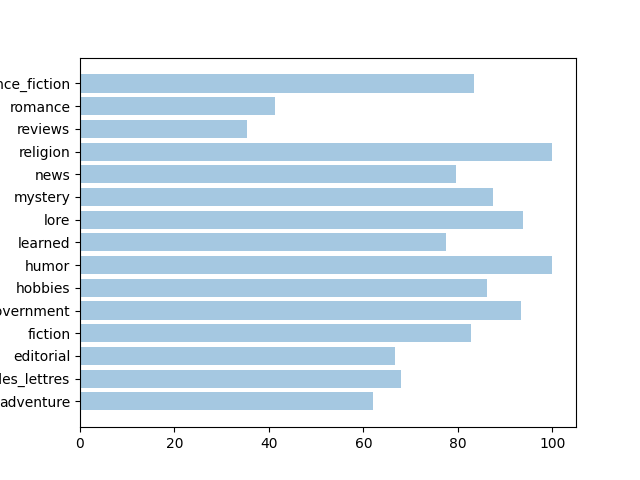

: 

: 

: 

In [ ]:
from common.features import RelativeInverseDocumentWordFrequecies , AbsoluteTermFrequencies

bow3 = BagOfWords(vocabulary, term_weighting=RelativeInverseDocumentWordFrequecies(vocabulary ,category_wordlists_dict ))
category_bow_dict3 = bow3.category_bow_dict(category_wordlists_dict)
processCategoryBowDict(category_bow_dict3)

Evaluieren Sie die beste Klassifikationsleistung.

Ermitteln Sie nun die Parameter für die beste Klassifikationsleistung des k-nächste-Nachbarn Klassifikators auf dem Brown Corpus mit der Kreuzvalidierung. Dabei wird gleichzeitig immer nur ein Parameter verändert. Man hat eine lokal optimale Parameterkonfiguration gefunden, wenn jede Änderung eines Parameters zu einer Verschlechterung der Fehlerrate führt.

Erläutern Sie warum eine solche Parameterkonfiguration lokal optimal ist.

Testen Sie mindestens die angegebenen Werte für die folgenden Parameter:
1. Größe des Vokabulars typischer Wörter (100, 500, 1000, 2000)
2. Gewichtung der Bag-of-Words Histogramme (absolute, relative, relative with inverse document frequency)
3. Distanzfunktion für die Bestimmung der nächsten Nachbarn (Cityblock, Euclidean, Cosine)
4. Anzahl der betrachteten nächsten Nachbarn (1, 2, 3, 4, 5, 6)

Erklären Sie den Effekt aller Parameter.

Erklären Sie den Effekt zwischen Gewichtungsschema und Distanzfunktion.

In [ ]:

def testWithParameters(voccSize , termWeightingFactory , distanceFunction ,  numKNeighbors):

	vocabulary = BagOfWords.most_freq_words(stemmed_words , voccSize)
	termWeighting = termWeightingFactory(vocabulary , category_wordlists_dict)
	bow = BagOfWords(vocabulary, term_weighting=termWeighting)
	category_bow_dict = bow.category_bow_dict(category_wordlists_dict)

	cv = CrossValidation(category_bow_dict , 5)
	knn_classifier = KNNClassifier(k_neighbors=numKNeighbors, metric=distanceFunction)
	crossval_overall_result, _ = cv.validate(knn_classifier)
	return  crossval_overall_result


voccSize = [100 , 500 , 1000 , 2000 ]
distanceFuncs = ["euclidean" , "cityblock", "cosine"]
neighbors = [1, 2, 3, 4, 5, 6]
bestCrossValidationResult = 0
bestCombination = ""
weightingFuncs = [
    {"func" : lambda _,__ : RelativeTermFrequencies() , "name" : "relative term frequencies"} ,
    {"func" : lambda _,__: AbsoluteTermFrequencies()  , "name" : "absolute term frequencies" },
    { "func" : lambda vocab , cat_wordlists_dict: RelativeInverseDocumentWordFrequecies(vocab , cat_wordlists_dict) , "name" : "relative inverse document frequencies" }
    ]
for vSize in voccSize:
	for distFunc in distanceFuncs:
		for n in neighbors:
			for weightFunctionDict in weightingFuncs:
				func_name = weightFunctionDict["name"]
				combination = f"test vsize={vSize} distFunc={distFunc} neighbors={n} freq_func={func_name}"
				print(combination)
				crossval_overall_result = testWithParameters(vSize , weightFunctionDict["func"], distFunc , n)
				print("cross val overall result" , crossval_overall_result)
				if crossval_overall_result > bestCrossValidationResult:
					bestCrossValidationResult = crossval_overall_result
					bestCombination = combination

testing with vsize=100 distFunc=euclidean neighbors=1
cross val overall result 77.2
testing with vsize=100 distFunc=euclidean neighbors=2
cross val overall result 74.00000000000001
testing with vsize=100 distFunc=euclidean neighbors=3
cross val overall result 72.6
testing with vsize=100 distFunc=euclidean neighbors=4
cross val overall result 71.4
testing with vsize=100 distFunc=euclidean neighbors=5
cross val overall result 73.4
testing with vsize=100 distFunc=euclidean neighbors=6
cross val overall result 71.8
testing with vsize=100 distFunc=cityblock neighbors=1
cross val overall result 71.2
testing with vsize=100 distFunc=cityblock neighbors=2
cross val overall result 73.0
testing with vsize=100 distFunc=cityblock neighbors=3
cross val overall result 70.2
testing with vsize=100 distFunc=cityblock neighbors=4
cross val overall result 66.6
testing with vsize=100 distFunc=cityblock neighbors=5
cross val overall result 64.80000000000001
testing with vsize=100 distFunc=cityblock neighbor

: 

: 

: 

: 